# Reproduce onboard solution for validation testing

In [31]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [32]:
from glob import glob
from astropy.table import Table
import os
import matplotlib.pyplot as plt
import numpy as np
from Quaternion import Quat
import os
import Ska.File
from Ska.Shell import bash
from glob import glob
import mica.quaternion

First, let's look at some basically nominal data

In [33]:
# 18022 is a nominal observation with good bright stars
obsid = 18022

In [34]:
obsdir = 'obs{}'.format(obsid)
if not os.path.exists(obsdir):
    os.makedirs(obsdir)

These are using a param-setting option in runasp in development.  To be fixed

In [35]:
# Remake the nominal solution with all slots
if not os.path.exists(os.path.join(obsdir, 'pipeline_out', 'fullpipe_all_slots')):
    with Ska.File.chdir(obsdir):
        bash("~/git/runasp/runasp.py --obsid {} --label fullpipe_all_slots ".format(obsid))
asol_all_slot = Table.read(glob("{}/pipeline_out/fullpipe_all_slots/out1/*asol*".format(obsdir))[0])
asol = asol_all_slot
osol = Table.read(glob("{}/pipeline_out/fullpipe_all_slots/out1/*osol*".format(obsdir))[0])

In [36]:
# Set forward kalman to use first moment centroids and a large sigma
if not os.path.exists(os.path.join(obsdir, 'pipeline_out', 'fullpipe_large_sigma')):
    with Ska.File.chdir(obsdir):
        bash("~/git/runasp/runasp.py --obsid {} --label fullpipe_large_sigma --param 'asp_l1_std kalman_alg=FM kalman_sigedit=100\
00'".format(obsid))
asol_fm_ls = Table.read(glob("{}/pipeline_out/fullpipe_large_sigma/out1/*asol*".format(obsdir))[0])


In [37]:
# Get the tkalm values for these
tkalm = Table.read(glob("{}/pipeline_out/fullpipe_all_slots/out1/*tklmn*".format(obsdir))[0])
tkalm_ls = Table.read(glob("{}/pipeline_out/fullpipe_large_sigma/out1/*tklmn*".format(obsdir))[0])


In [38]:
# Get a number (from target quaternion) for a reference roll to use for these observations
def three_to_four_quat(qt1, qt2, qt3):
    qt4 = np.sqrt(np.abs(1.0 - qt1**2 - qt2**2 - qt3**2))
    return mica.quaternion.normalize(np.column_stack([qt1, qt2, qt3, qt4]))
from kadi import events
ds = events.dwells.filter(obsid=obsid)
from Ska.engarchive import fetch
targqt = fetch.Msidset(['AOTARQT{}'.format(i) for i in [1, 2, 3]], ds[0].tstart, ds[0].tstart + 50)
targquat = three_to_four_quat(targqt['AOTARQT1'].vals[0],
                              targqt['AOTARQT2'].vals[0],
                              targqt['AOTARQT3'].vals[0])[0]
acal = Table.read(glob("{}/pipeline_out/fullpipe_all_slots/out1/*acal*".format(obsdir))[0])
aca_misalign = np.array(acal['aca_misalign'].reshape(3,3))
MNC_targquat = Quat(np.dot(Quat(targquat).transform, aca_misalign))
targquat = Quat(targquat)


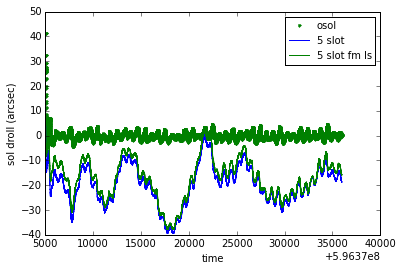

In [39]:
figure()
plot(osol['time'], 3600 * (osol['roll'] - MNC_targquat.roll), 'g.', label='osol')
plot(asol['time'], 3600 * (asol_all_slot['roll'] - MNC_targquat.roll), label='5 slot')
plot(asol['time'], 3600 * (asol_fm_ls['roll'] - MNC_targquat.roll), label='5 slot fm ls')
legend(fontsize=10, numpoints=1)
xlabel('time')
ylabel('sol droll (arcsec)')
savefig('sol_rolls.png')

The full-pipe smoothed aspect solutions have a lot more roll variation than osol.  How do the tkalm values compare?

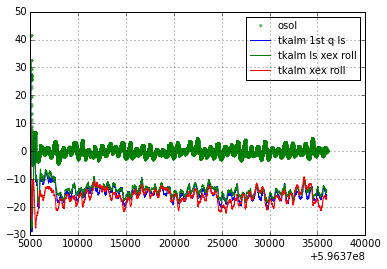

In [40]:
figure()
plot(osol['time'], 3600 * (osol['roll'] - MNC_targquat.roll), 'g.', label='osol', alpha=.5)
plot(tkalm_ls['time'], 3600 * ((mica.quaternion.Quat(tkalm_ls['quat'][:,0:4])).roll - targquat.roll), label='tkalm 1st q\
 ls')
plot(tkalm_ls['time'], 3600 * np.degrees(tkalm_ls['xexdat'][:,0]), label='tkalm ls xex roll')
plot(tkalm['time'], 3600 * np.degrees(tkalm['xexdat'][:,0]), label='tkalm xex roll')
legend(fontsize=10, numpoints=1)
grid()


The tkalm xex "roll" deltas for the large sigma and regular solutions, and the first quaternion in the tkalm file both appear to be offset by ~16 arcsecs in roll from target quaternion roll (and obviously osol is pretty closed to centered on that).  Is this true for other observations?

In [41]:
obsid = 19786
obsdir = 'obs{}'.format(obsid)
if not os.path.exists(obsdir):
    os.makedirs(obsdir)
if not os.path.exists(os.path.join(obsdir, 'pipeline_out', 'fullpipe_all_slots')):
    with Ska.File.chdir(obsdir):
        bash("~/git/runasp/runasp.py --obsid {} --label fullpipe_all_slots ".format(obsid))
asol_all_slot = Table.read(glob("{}/pipeline_out/fullpipe_all_slots/out1/*asol*".format(obsdir))[0])
asol = asol_all_slot
osol = Table.read(glob("{}/pipeline_out/fullpipe_all_slots/out1/*osol*".format(obsdir))[0])
if not os.path.exists(os.path.join(obsdir, 'pipeline_out', 'fullpipe_large_sigma')):
    with Ska.File.chdir(obsdir):
        bash("~/git/runasp/runasp.py --obsid {} --label fullpipe_large_sigma --param 'asp_l1_std kalman_alg=FM kalman_sigedit=100\
00'".format(obsid))
asol_fm_ls = Table.read(glob("{}/pipeline_out/fullpipe_large_sigma/out1/*asol*".format(obsdir))[0])
tkalm = Table.read(glob("{}/pipeline_out/fullpipe_all_slots/out1/*tklmn*".format(obsdir))[0])
tkalm_ls = Table.read(glob("{}/pipeline_out/fullpipe_large_sigma/out1/*tklmn*".format(obsdir))[0])
ds = events.dwells.filter(obsid=obsid)
targqt = fetch.Msidset(['AOTARQT{}'.format(i) for i in [1, 2, 3]], ds[0].tstart, ds[0].tstart + 50)
targquat = three_to_four_quat(targqt['AOTARQT1'].vals[0],
                              targqt['AOTARQT2'].vals[0],
                              targqt['AOTARQT3'].vals[0])[0]
acal = Table.read(glob("{}/pipeline_out/fullpipe_all_slots/out1/*acal*".format(obsdir))[0])
aca_misalign = np.array(acal['aca_misalign'].reshape(3,3))
MNC_targquat = Quat(np.dot(Quat(targquat).transform, aca_misalign))
targquat = Quat(targquat)


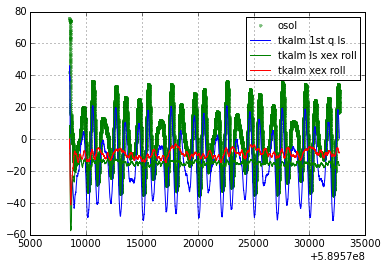

In [42]:
figure()
plot(osol['time'], 3600 * (osol['roll'] - MNC_targquat.roll), 'g.', label='osol', alpha=.5)
plot(tkalm_ls['time'], 3600 * ((mica.quaternion.Quat(tkalm_ls['quat'][:,0:4])).roll - targquat.roll), label='tkalm 1st q\
 ls')
plot(tkalm_ls['time'], 3600 * np.degrees(tkalm_ls['xexdat'][:,0]), label='tkalm ls xex roll')
plot(tkalm['time'], 3600 * np.degrees(tkalm['xexdat'][:,0]), label='tkalm xex roll')
legend(fontsize=10, numpoints=1)
grid()

(589585000.0, 589587000.0)

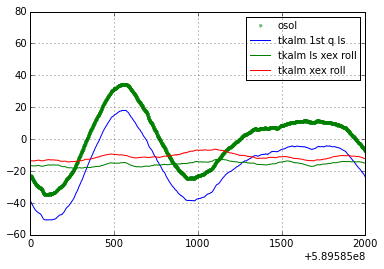

In [43]:
figure()
offset = 0
plot(osol['time'], 3600 * (osol['roll'] - MNC_targquat.roll), 'g.', label='osol', alpha=.5)
plot(tkalm_ls['time'], offset + 3600 * ((mica.quaternion.Quat(tkalm_ls['quat'][:,0:4])).roll - targquat.roll), label='tkalm 1st q\
 ls')
plot(tkalm_ls['time'], offset + 3600 * np.degrees(tkalm_ls['xexdat'][:,0]), label='tkalm ls xex roll')
plot(tkalm['time'], offset + 3600 * np.degrees(tkalm['xexdat'][:,0]), label='tkalm xex roll')
legend(fontsize=10, numpoints=1)
grid()
xlim(589575000.0 + 10000, 589575000.0 + 12000)

(589585000.0, 589587000.0)

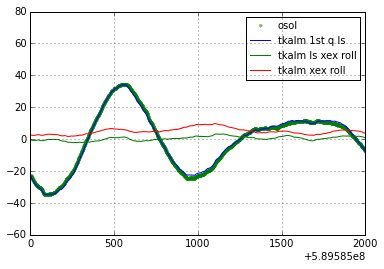

In [44]:
figure()
offset = 16
plot(osol['time'], 3600 * (osol['roll'] - MNC_targquat.roll), 'g.', label='osol', alpha=.5)
plot(tkalm_ls['time'], offset + 3600 * ((mica.quaternion.Quat(tkalm_ls['quat'][:,0:4])).roll - targquat.roll), label='tkalm 1st q\
 ls')
plot(tkalm_ls['time'], offset + 3600 * np.degrees(tkalm_ls['xexdat'][:,0]), label='tkalm ls xex roll')
plot(tkalm['time'], offset + 3600 * np.degrees(tkalm['xexdat'][:,0]), label='tkalm xex roll')
legend(fontsize=10, numpoints=1)
grid()
xlim(589575000.0 + 10000, 589575000.0 + 12000)

OK so the 16 arcsec offset persists across observations and the xex values must be relative to a moving value (or already included in the first quaternion in the tkalm file) as they don't look very useful vs a fixed value.

In [45]:
obsid = 19846

bad_slot = 4
obsdir = 'obs{}'.format(obsid)
if not os.path.exists(obsdir):
    os.makedirs(obsdir)
if not os.path.exists(os.path.join(obsdir, 'pipeline_out', 'fullpipe_skip_bad')):                                                
    with Ska.File.chdir(obsdir):                                                                                                 
        bash("~/git/runasp/runasp.py --obsid {} --label fullpipe_skip_bad --skip-slot {} ".format(obsid, bad_slot))              
full_skip_bad = Table.read(glob("{}/pipeline_out/fullpipe_skip_bad/out1/*asol*".format(obsdir))[0])                              
asol = full_skip_bad                                                                                                             
osol = Table.read(glob("{}/pipeline_out/fullpipe_skip_bad/out1/*osol*".format(obsdir))[0])  
if not os.path.exists(os.path.join(obsdir, 'pipeline_out', 'fullpipe_all_slots')):
    with Ska.File.chdir(obsdir):
        bash("~/git/runasp/runasp.py --obsid {} --label fullpipe_all_slots ".format(obsid))
asol_all_slot = Table.read(glob("{}/pipeline_out/fullpipe_all_slots/out1/*asol*".format(obsdir))[0])
if not os.path.exists(os.path.join(obsdir, 'pipeline_out', 'fullpipe_large_sigma')):
    with Ska.File.chdir(obsdir):
        bash("~/git/runasp/runasp.py --obsid {} --label fullpipe_large_sigma --param 'asp_l1_std kalman_alg=FM kalman_sigedit=100\
00'".format(obsid))
asol_fm_ls = Table.read(glob("{}/pipeline_out/fullpipe_large_sigma/out1/*asol*".format(obsdir))[0])

ds = events.dwells.filter(obsid=obsid)

targqt = fetch.Msidset(['AOTARQT{}'.format(i) for i in [1, 2, 3]], ds[0].tstart, ds[0].tstart + 50)
targquat = three_to_four_quat(targqt['AOTARQT1'].vals[0],
                              targqt['AOTARQT2'].vals[0],
                              targqt['AOTARQT3'].vals[0])[0]
acal = Table.read(glob("{}/pipeline_out/fullpipe_all_slots/out1/*acal*".format(obsdir))[0])
aca_misalign = np.array(acal['aca_misalign'].reshape(3,3))
MNC_targquat = Quat(np.dot(Quat(targquat).transform, aca_misalign))
targquat = Quat(targquat)


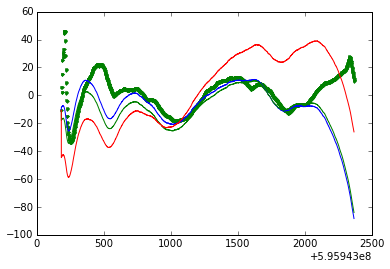

In [46]:
figure()
plot(osol['time'], 3600 * (osol['roll'] - MNC_targquat.roll), 'g.', label='osol')
plot(asol['time'], 3600 * (asol['roll'] - MNC_targquat.roll), label='4 slot')
plot(asol_all_slot['time'], 3600 * (asol_all_slot['roll'] - MNC_targquat.roll), label='5 slot')
plot(asol_fm_ls['time'], 3600 * (asol_fm_ls['roll'] - MNC_targquat.roll), label='5 slot fm ls')

So, for this observation even the "worst" ground aspect solution (5 stars first moment centroids large sigma allowed)  seems to follow the roll at the end and not behave at all like the onboard solution.

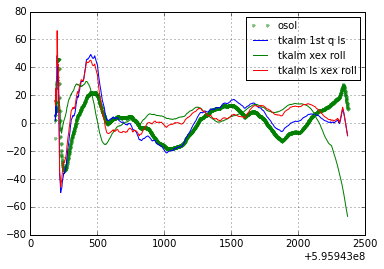

In [50]:
figure()
tkalm = Table.read(glob("{}/pipeline_out/fullpipe_all_slots/out1/*tklmn*".format(obsdir))[0])
tkalm_ls = Table.read(glob("{}/pipeline_out/fullpipe_large_sigma/out1/*tklmn*".format(obsdir))[0])

offset = 16
plot(osol['time'], 3600 * (osol['roll'] - MNC_targquat.roll), 'g.', label='osol', alpha=.5)
plot(tkalm_ls['time'], offset + 3600 * ((mica.quaternion.Quat(tkalm_ls['quat'][:,0:4])).roll - targquat.roll), label='tkalm 1st q\
 ls')
plot(tkalm['time'], offset + 3600 * np.degrees(tkalm['xexdat'][:,0]), label='tkalm xex roll')
plot(tkalm_ls['time'], offset + 3600 * np.degrees(tkalm_ls['xexdat'][:,0]), label='tkalm ls xex roll')
grid()
legend(fontsize=10)

The more raw values in the large sigma tkalm seem to have some of the osol feature of interest at the end